# Reading datasets forming a new one

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/eng_prem'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR', 'HST', 'AST', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.head(5)

Number of rows: 8248
Number of columns: 13


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HST,AST,B365H,B365D,B365A
0,17/08/2002,Blackburn,Sunderland,0.0,0.0,0.0,0.0,D,5.0,3.0,1.727,3.25,4.333
1,17/08/2002,Charlton,Chelsea,2.0,3.0,2.0,1.0,A,5.0,12.0,2.800,3.25,2.200
2,17/08/2002,Everton,Tottenham,2.0,2.0,1.0,0.0,D,9.0,5.0,2.250,3.25,2.750
3,17/08/2002,Fulham,Bolton,4.0,1.0,3.0,1.0,H,6.0,1.0,1.727,3.25,4.333
4,17/08/2002,Leeds,Man City,3.0,0.0,2.0,0.0,H,8.0,10.0,1.667,3.40,4.500


# Adding Moving Averages

In [10]:
#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals for halftime
df['HTHGS'] = df.groupby('HomeTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTHGC'] = df.groupby('HomeTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['HTAGS'] = df.groupby('AwayTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTAGC'] = df.groupby('AwayTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['ht_home_form'] = df['HTHGS'] - df['HTHGC']
df['ht_away_form'] = df['HTAGS'] - df['HTAGC']

#Calculating shots on target for home/away
df['HSTS'] = df.groupby('HomeTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HSTC'] = df.groupby('HomeTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['ASTS'] = df.groupby('AwayTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['ASTC'] = df.groupby('AwayTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['home_shot_adv'] = df['HSTS'] - df['HSTC']
df['away_shot_adv'] = df['ASTS'] - df['ASTC']

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']
df['xg_dif'] = df['home_xg'] - df['away_xg']

df.dropna(inplace = True)
df = df.reset_index(drop = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]
df['form_dif'] = df['HPPG'] - df['APPG']

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'xg_dif', 'home_shot_adv', 'away_shot_adv',
            'HST', 'AST', 'HSTS', 'HSTC', 'ASTS', 'ASTC', 'HTHG', 'HTAG',
            'HTHGS', 'HTHGC', 'HTAGS', 'HTAGC'], axis = 1, inplace = True)



df[df['HomeTeam'] == 'Everton'].head(7)

,HomeTeam,AwayTeam,FTR,HPPG,APPG,ht_home_form,ht_away_form,FTH,FTDA,home_poisson,away_poisson,poisson_df,FTRT,form_dif
4,Everton,Birmingham,D,1.000000,0.000000,1.000000,-2.00,0.536974,0.463026,2,0,2,0,1.000000
31,Everton,Middlesbrough,H,1.000000,0.500000,0.500000,-0.50,0.389014,0.610986,0,0,0,1,0.500000
52,Everton,Fulham,H,1.666667,1.333333,0.333333,0.00,0.398329,0.601671,1,2,-1,1,0.333333
69,Everton,Arsenal,H,2.000000,2.000000,0.750000,0.25,0.162360,0.837640,1,2,-1,1,0.000000
103,Everton,Charlton,H,2.200000,0.800000,0.600000,0.20,0.537421,0.462579,1,0,1,1,1.400000
121,Everton,West Brom,H,2.600000,0.800000,0.600000,0.20,0.622124,0.377876,1,0,1,1,1.800000
142,Everton,Chelsea,A,3.000000,1.200000,0.800000,0.00,0.359551,0.640449,0,0,0,0,1.800000


# Adding Points Table

In [11]:
#Creating Table According to Performance
point = 0
game = 0
teams = np.unique(df['HomeTeam'])

points = []
games = []
team_names = []

for team in teams:
    for j in range(len(df['HomeTeam'])):
        if team == df['HomeTeam'][j]:
            game += 1
            if df['FTR'][j] == 'H':
                point += 3
            elif df['FTR'][j] == 'D':
                point += 1
        elif team == df['AwayTeam'][j]:
            game += 1
            if df['FTR'][j] == 'A':
                point += 3
            elif df['FTR'][j] == 'D':
                point += 1
    points.append(point)
    team_names.append(team)
    games.append(game)
    point = 0
    ft_scored = 0
    ft_conceded = 0
    ht_scored = 0
    ht_conceded = 0
    game = 0


table = pd.DataFrame({
    'Teams': team_names,
    'Points': points,
    'Games': games,
})

table['PPG'] = table['Points'] / table['Games']
table = table.sort_values(by = 'PPG', ascending = False).reset_index(drop = True)
table

,Teams,Points,Games,PPG
0,Man United,1644,820,2.004878
1,Chelsea,1607,819,1.962149
2,Arsenal,1584,821,1.929354
3,Liverpool,1568,821,1.909866
4,Man City,1550,817,1.897185
5,Tottenham,1376,821,1.676005
6,Everton,1168,820,1.424390
7,Leicester,508,372,1.365591
8,Newcastle,962,743,1.294751
9,Blackburn,466,366,1.273224


In [12]:
# Create a dictionary mapping team names to their indices
team_indices = {team: index + 1 for index, team in enumerate(table['Teams'])}

# Create a dictionary mapping team names to points
team_points_dict = table.set_index('Teams')['PPG'].to_dict()

# Map points to home team in df_matches
df['HomePoints'] = df['HomeTeam'].map(team_points_dict)
df['AwayPoints'] = df['AwayTeam'].map(team_points_dict)

# Replace 'home' and 'away' team names with their indices from df2
df['HomeTeam'] = df['HomeTeam'].map(team_indices)
df['AwayTeam'] = df['AwayTeam'].map(team_indices)

df['Difference'] = df['AwayTeam'] - df['HomeTeam']
df['PpgDif'] = df['HomePoints'] - df['AwayPoints']

df.tail(10)

,HomeTeam,AwayTeam,FTR,HPPG,APPG,ht_home_form,ht_away_form,FTH,FTDA,home_poisson,away_poisson,poisson_df,FTRT,form_dif,HomePoints,AwayPoints,Difference,PpgDif
8172,41,7,D,0.8,0.4,-1.2,-1.4,0.364720,0.635280,1,0,1,0,0.4,0.764706,1.424390,-34,-0.659684
8173,3,23,H,2.4,1.4,1.0,0.4,0.785191,0.214809,1,0,1,1,1.0,1.929354,1.137405,20,0.791950
8174,12,24,D,1.2,1.4,-0.4,-0.4,0.452718,0.547282,1,1,0,0,-0.2,1.245455,1.133446,12,0.112009
8175,30,9,A,1.0,1.2,-0.4,-0.4,0.278273,0.721727,0,1,-1,0,-0.2,1.023669,1.294751,-21,-0.271082
8176,37,34,A,0.4,0.2,-1.8,-0.6,0.199611,0.800389,1,2,-1,0,0.2,0.878378,0.944444,-3,-0.066066
8177,5,20,H,2.6,1.0,0.2,-0.4,0.876095,0.123905,2,0,2,1,1.6,1.897185,1.167116,15,0.730069
8178,15,11,H,1.4,2.0,0.0,0.2,0.350167,0.649833,0,2,-2,1,-0.6,1.211538,1.270538,-4,-0.059000
8179,2,13,H,2.6,1.2,1.2,-0.8,0.576923,0.423077,4,1,3,1,1.4,1.962149,1.233894,11,0.728255
8180,4,6,H,2.0,0.8,-0.4,-0.8,0.640669,0.359331,2,0,2,1,1.2,1.909866,1.676005,2,0.233861
8181,21,1,H,2.0,1.0,0.8,0.2,0.402468,0.597532,2,1,1,1,1.0,1.159193,2.004878,-20,-0.845685


# Trying with Random Forest


Random Forest - Training Accuracy: 0.8342245989304813
Random Forest - Test Accuracy: 0.6511912034208919


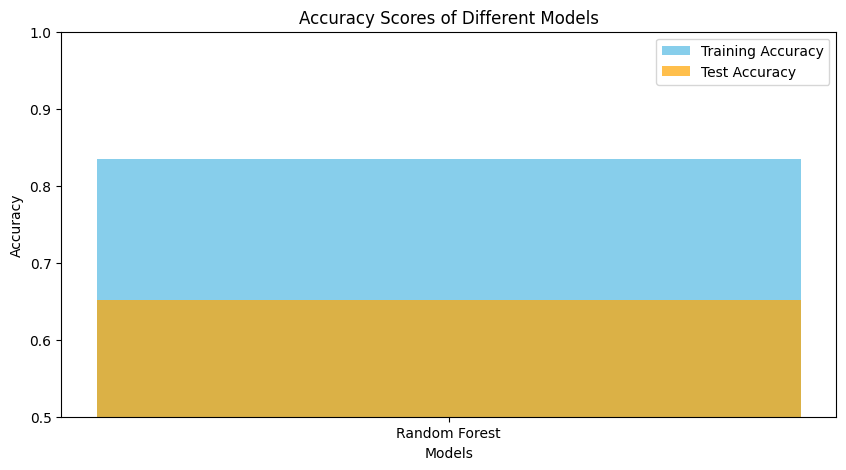

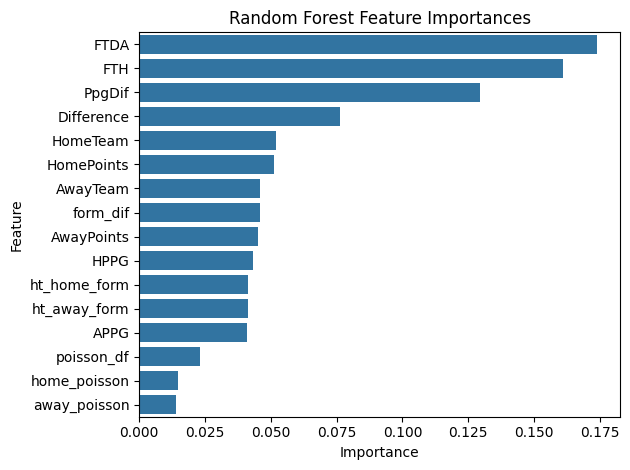

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       895
           1       0.61      0.66      0.63       742

    accuracy                           0.65      1637
   macro avg       0.65      0.65      0.65      1637
weighted avg       0.65      0.65      0.65      1637

Confusion Matrix:
[[578 317]
 [254 488]]
ROC AUC Score: 0.6517459982833651


In [13]:
# Split the data into training and testing sets
X = df.drop(columns=['FTRT', 'FTR'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,
                                          sampling_strategy = 'all', replacement = True, bootstrap = False)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize accuracy scores
models = ['Random Forest']
train_accuracies = [rf_train_accuracy]
test_accuracies = [rf_test_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, train_accuracies, color='skyblue', label='Training Accuracy')
plt.bar(models, test_accuracies, color='orange', alpha=0.7, label='Test Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]  # Probabilities of positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = roc_auc

# Print ROC AUC scores
for name, roc_auc in results.items():
    print(f'{name}: ROC AUC = {roc_auc}')


c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: ROC AUC = 0.7239033865891671
Random Forest: ROC AUC = 0.6897272959990364
Support Vector Machine: ROC AUC = 0.6948997876793808
Naive Bayes: ROC AUC = 0.7091508681052268
Gradient Boosting: ROC AUC = 0.7119328705446551
Decision Tree: ROC AUC = 0.5687700462286738
k-Nearest Neighbors: ROC AUC = 0.6281799153729163


ROC AUC Score: 0.7225300787543856
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       895
           1       0.62      0.65      0.63       742

    accuracy                           0.66      1637
   macro avg       0.66      0.66      0.66      1637
weighted avg       0.66      0.66      0.66      1637



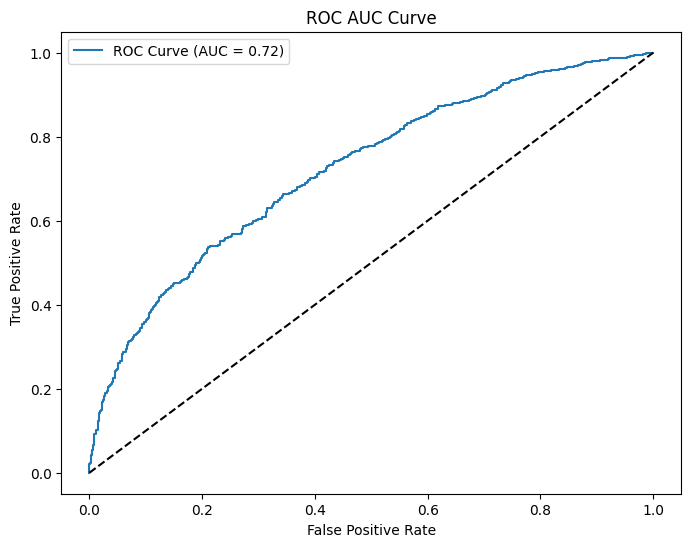

[[591 304]
 [256 486]]


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize and train Logistic Regression model with best hyperparameters
logistic_regression = LogisticRegression(C=10, class_weight='balanced', penalty='l1', solver='liblinear')
logistic_regression.fit(X_train, y_train)

# Generate predictions on the test set
y_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Generate classification report
y_pred = logistic_regression.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

print(confusion_matrix(y_test, y_pred))